This notebooks acts as a programming exercise, where we re-implement the work done in the paper titled: <br> 
"**Depth Map Prediction from Single Image  using a Multi-Scale Deep Network**" <br>
Paper URL: https://arxiv.org/pdf/1406.2283

In the above paper, the authors try to predict a 2D map where each value in the map represents the depth of the corresponding pixel in the input image from the camera. 

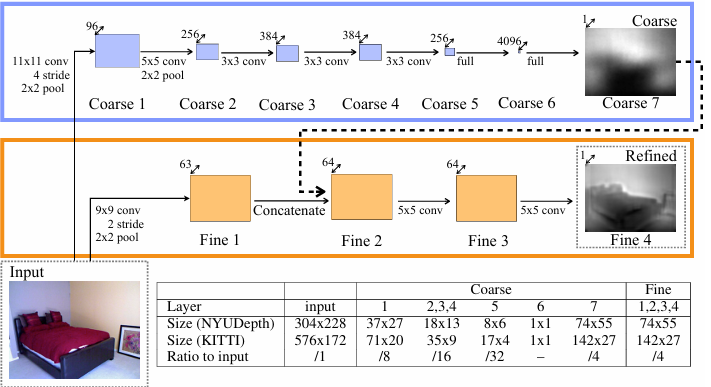

The authors came up with a CNN based approach, where the input image is fed to a coarse network (global view) and another network for finer details or smoothing the output of the coarse net.

# Import Libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

import os

import torch
from torch import nn

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as v2
from torchvision.io import read_image

import warnings
warnings.filterwarnings("ignore")


In [ ]:
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Data Preparation

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, df_dir):
        self.df_dir = df_dir
        self.root_dir = root_dir
        self.df = pd.read_csv(df_dir,
                             header = None,
                             names = ['image', 'depth'])
        
        img_RESIZE_SHAPE = (228, 304) # (240, 320)
        depth_RESIZE_SHAPE = (74, 55)
        self.img_transform = v2.Resize(img_RESIZE_SHAPE)
        self.depth_transform = v2.Resize(depth_RESIZE_SHAPE)
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        img_dir = self.root_dir + self.df.iloc[idx]['image']
        depth_dir = self.root_dir + self.df.iloc[idx]['depth']
        img = read_image(img_dir)
        depth = read_image(depth_dir)
        img_resize = self.img_transform(img)
        depth_resize = self.depth_transform(depth)
        
        return img_resize.to(torch.float32)/255.0, depth_resize.to(torch.float32)/255.0
        
        
        

In [ ]:
TRAIN_CSV_PATH = "/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_train.csv"
ROOT_PATH = "/kaggle/input/nyu-depth-v2/nyu_data/"

# Optional Data Augmentation
* Scale: Input and target images are scaled by s ∈ [1, 1.5], and the depths are divided by s.

* Rotation: Input and target are rotated by r ∈ [−5, 5] degrees.

* Translation: Input and target are randomly cropped to the sizes indicated in Fig. 1.

* Color: Input values are multiplied globally by a random RGB value c ∈ [0.8, 1.2]3.

* Flips: Input and target are horizontally flipped with 0.5 probability

# Modeling

### Coarse (Global Level) Network


-----
Pretraining these layers on ImageNet gives slightly better performance

1.   11x11 Conv (relu) (4 stride) (96 filters)
2.   2x2 MaxPool
3.   5x5 Conv (relu) (256 filters)
4.   2x2 MaxPool
5.   3x3 Conv (relu) (384 filters)
6.   3x3 Conv (relu) (384 filters)
7.   3x3 Conv (relu) (256 filters)
-----
8.   FullyConnected Layer (relu) (dims 4096)
9.   DropOut
10.  Fully Connected Layer (linear) (dims 1)



In [ ]:
class CoarseNet(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        self.c1 = nn.Conv2d(in_channels=input_shape, 
                            out_channels=96, 
                            kernel_size = 11, 
                            stride = 4)
        self.a1 = nn.ReLU()
        
        self.m1 = nn.MaxPool2d(2) 
        
        self.c2 = nn.Conv2d(in_channels = 96, 
                            out_channels = 256, 
                            kernel_size = 5,
                            padding = 'same')
        self.a2 = nn.ReLU()
        
        self.m2 = nn.MaxPool2d(2)
        
        self.c3 = nn.Conv2d(in_channels = 256, 
                            out_channels = 384, 
                            kernel_size = 3,
                            padding = 'same')
        self.a3 = nn.ReLU()
        
        self.c4 = nn.Conv2d(in_channels = 384, 
                            out_channels = 384, 
                            kernel_size = 3,
                            padding = 'same')
        self.a4 = nn.ReLU()
        
        self.c5 = nn.Conv2d(in_channels = 384, 
                            out_channels = 256, 
                            kernel_size = 3,
                            stride = 2)
        self.a5 = nn.ReLU()
        
        self.flat6 = nn.Flatten() 
        self.f6 = nn.Linear(256*8*6, 4096)
        self.d6 = nn.Dropout()
        
        self.f7 = nn.Linear(4096, 74*55)
        self.a7 = nn.ReLU()
    
    def forward(self, x):
        #print(torch.mean(x))
        x = self.c1(x)
        x = self.a1(x)
        x = self.m1(x)
        #print("l1: ", x.shape)
        
        #print(torch.mean(x))
        
        x = self.c2(x)
        x = self.a2(x)
        x = self.m2(x)
        #print("l2: ", x.shape)
        
        
        #print(torch.mean(x))
        
        x = self.c3(x)
        x = self.a3(x)
        #print("l3: ", x.shape)
        
        
        #print(torch.mean(x))
        
        x = self.c4(x)
        x = self.a4(x)
        #print("l4: ", x.shape)
        
        #print(torch.mean(x))
        
        x = self.c5(x)
        x = self.a5(x)
        #print("l5: ", x.shape)
        
        #print(torch.mean(x))
        
        x = self.flat6(x)
        x = self.f6(x)
        x = self.d6(x)
        #print("l6: ", x.shape)
        
        
        #print(torch.mean(x))
        
        x = self.f7(x)
        x = self.a7(x)
        
        x = x.view(-1, 1, 74, 55)
        
        
        #print(torch.mean(x))
        #print("---------------------")
        #print(x[0, :, 0:5, 0:5])
        #print("l7: ", x.shape)
        return x
        
                

### Fine details Network

1.   9x9 Conv (relu) (2 stride) (63 filters)
2.   2x2 MaxPool
3.   Concatenate with output of coarse network
4.   5x5 Conv (relu) (64 filters)
5.   5x5 Conv (linear) (1 filter)

**Note: Coarse network is trained first then fine network is trained after.**


calculating the difference between depth i and depth j in predicted map and comparing it to depth i and depth j in the ground truth map and trying to minimize the difference between them will lead to a scale invaraint loss

In [ ]:
class FineNet(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        self.c1 = nn.Conv2d(in_channels=input_shape, 
                            out_channels=63, 
                            kernel_size = 9, 
                            stride = 2)
        self.a1 = nn.ReLU()
        
        self.m1 = nn.MaxPool2d(2) 
        
        self.c2 = nn.Conv2d(in_channels = 64, 
                            out_channels = 64, 
                            kernel_size = 5,
                            padding = 'same')
        self.a2 = nn.ReLU()
        
        
        self.c3 = nn.Conv2d(in_channels = 64, 
                            out_channels = 64, 
                            kernel_size = 5,
                            padding = 'same')
        self.a3 = nn.ReLU()
        
        self.c4 = nn.Conv2d(in_channels = 64, 
                            out_channels = 1, 
                            kernel_size = 5,
                            padding = 'same')
        self.a4 = nn.ReLU()
        
    def forward(self, x, x_coarse):
        x = x.permute(0, 1, 3, 2)
        x = self.c1(x)
        x = self.a1(x)
        x = self.m1(x)
        #print("l1: ", x.shape)
        
        x = torch.concat([x, x_coarse], dim = 1)
        x = self.c2(x)
        x = self.a2(x)
        #print("l2: ", x.shape)
        
        x = self.c3(x)
        x = self.a3(x)
        #print("l3: ", x.shape)
        
        x = self.c4(x)
        x = self.a4(x)
        #print("l4: ", x.shape)
        
        #x = self.c5(x)
        #x = self.a5(x)
        #print("l5: ", x.shape)
        
        #x = self.flat6(x)
        #x = self.f6(x)
        #x = self.d6(x)
        #print("l6: ", x.shape)
        
        #x = self.f7(x)
        #x = x.view(-1, 1, 74, 55)
        #print("l7: ", x.shape)
        return x
        
                

In [ ]:
cnet = CoarseNet(3)

In [ ]:
fnet = FineNet(3)

In [ ]:
# Optimizers specified in the torch.optim package
cnet_optimizer = torch.optim.SGD(cnet.parameters(), lr=0.5, momentum=0.9)
fnet_optimizer = torch.optim.SGD(fnet.parameters(), lr=0.01, momentum=0.9)

In [ ]:
EPOCHS = 1000
LAMBDA = 0.5
BATCH_SIZE = 8

In [ ]:
torch.cuda.empty_cache()

Now come to the loss function, there is a problem with this approach that it uses a single image which lacks depth information so there are actually infinite solutions to this problem as in the below image 
<br>
<br>
<br>
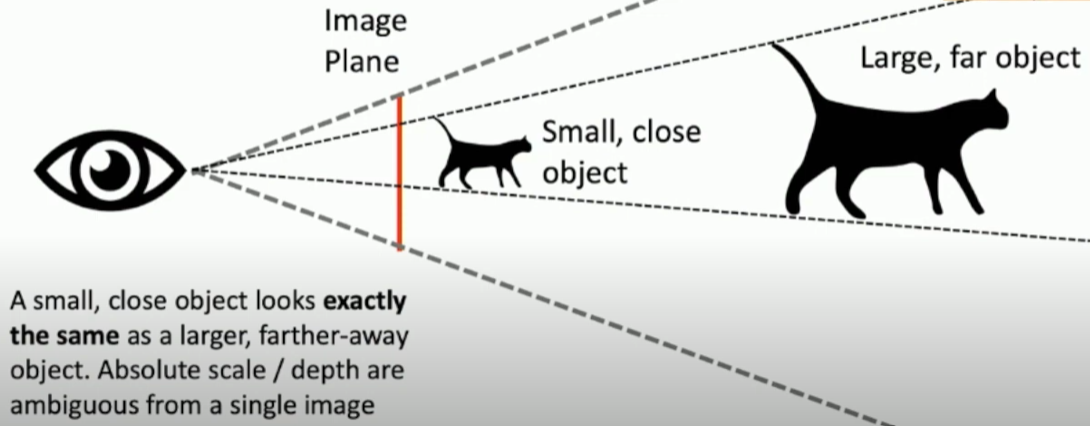
<br>
[source](https://www.youtube.com/watch?v=S1_nCdLUQQ8)

### **Training Loss and Evaluation Metric**

**Eval metric**: <br>
$\frac{1}{n}\sum_{i=1}^n d_i^2 - \frac{1}{n^2}(\sum_{i=1}^n d_i)^2$ <br>

<br>

**Training Loss**: <br>
$\frac{1}{n}\sum_{i=1}^n d_i^2 - \frac{\lambda}{n^2}(\sum_{i=1}^n d_i)^2$


where:

* $y$ is the predicted depth map

* $y^*$ is the ground truth depth map

* $d_i$ = $log(y_i) - log(y_{i}^{*})$

* $n$ is the number of pixels in the output depth map and ground truth depth map

* $λ$ is a hyper-parameter $\in$ [0, 1]

Note: you might need to exclude pixel values that have infinte depth from both metrics

The above loss tries to keep the difference between pixels in the same map as close as possible in the predicted map. <br> <br> <br>
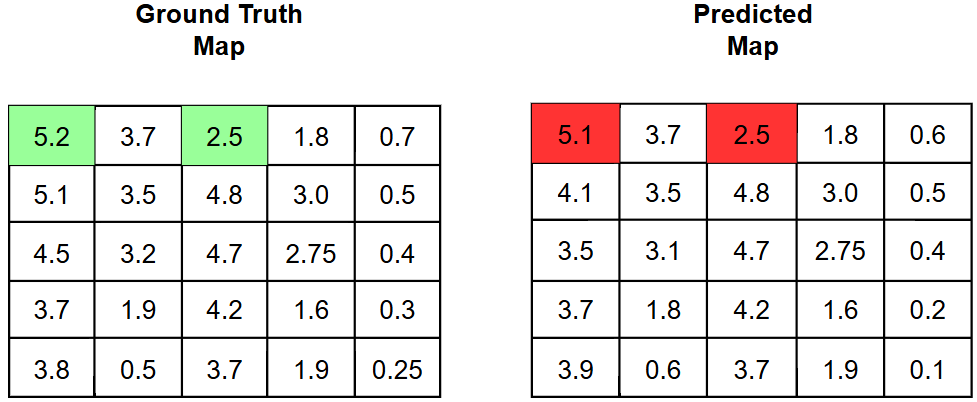
<br> <br> <br>
In other words, it tries to make the difference between the green pixels the same as the difference between the red pixels

In [ ]:
def scale_invariant_loss(y_true, y_pred):
    
    di = torch.log10(y_pred+0.01) - torch.log10(y_true+0.01) #y_pred - y_true #torch.log10(y_pred+0.01) - torch.log10(y_true+0.01)
    di = torch.flatten(di, start_dim = 1)

    loss = torch.mean(di**2) - LAMBDA * torch.mean(di)**2
    return loss
    
    

In [ ]:
scale_invariant_loss(torch.rand(32, 1, 74, 55), torch.rand(32, 1, 74, 55))

In [ ]:
IS_CUDA_AVAILABLE = torch.cuda.is_available()
if IS_CUDA_AVAILABLE:
    cnet = cnet.cuda()
    fnet = fnet.cuda()

In [ ]:
torch.cuda.memory_allocated()

In [ ]:
train_ds = CustomDataset(ROOT_PATH, TRAIN_CSV_PATH)
train_dataloader = DataLoader(train_ds, 
                              batch_size = BATCH_SIZE, 
                              shuffle = False,
                              num_workers = 5)

To save time, I will train the model on one batch to overfit, if the model managed to overfit then the model has the capacity to learn to predict the depth map from a single image, if not then this architecture needs tweaking

In [ ]:
loss_history = []
for i in range(EPOCHS):
    epoch_loss = 0
    for batch_idx, (x, y_true) in enumerate(train_dataloader):
        if IS_CUDA_AVAILABLE:
            x = x.cuda()
            y_true = y_true.cuda()
        cnet_optimizer.zero_grad()
        y_pred = cnet(x)
        
        
        loss = scale_invariant_loss(y_true, y_pred)
        loss.backward()
        cnet_optimizer.step()
        epoch_loss += loss.item()
        break
    if i % 50 == 0:
        print(f"epoch: {i} -- Loss: {epoch_loss}")
    loss_history.append(epoch_loss)
    

In [ ]:
plt.plot(np.arange(len(loss_history)), loss_history)
plt.xlabel('epochs')
plt.ylabel('scale invaraint loss')
plt.grid(axis='y', alpha = 0.2)

the loss goes perfectly down so the model can learn

In [ ]:
# torch.save(cnet.state_dict(), "/kaggle/working/cnet2.h5")

In [ ]:
for param in cnet.parameters():
    param.requires_grad = False


In [ ]:
x, y = train_ds[0]
if IS_CUDA_AVAILABLE:
    x = x.cuda()
y_coarse = cnet(x[None, ...])

y_coarse = y_coarse.cpu().squeeze().detach().numpy()
fig, axs = plt.subplots(1, 2, figsize = (10, 8))
axs[0].imshow(y.squeeze())
axs[1].imshow(y_coarse)


we can see some parts of the images like the chair on the lower bottom part of the image

Lets do the same with the fine net

In [ ]:
loss_history = []
for i in range(EPOCHS):
    epoch_loss = 0
    for batch_idx, (x, y_true) in enumerate(train_dataloader):
        if IS_CUDA_AVAILABLE:
            x = x.cuda()
            y_true = y_true.cuda()
        fnet_optimizer.zero_grad()
        y_coarse = cnet(x)
        
        y_pred = fnet(x, y_coarse)
        
        loss = scale_invariant_loss(y_true, y_pred)
        
        loss.backward()
        
        fnet_optimizer.step()
        
        epoch_loss += loss.item()
        break
    if i % 50 == 0:
        print(f"epoch: {i} -- Loss: {epoch_loss}")
    loss_history.append(epoch_loss)

In [ ]:
plt.plot(np.arange(len(loss_history)), loss_history)
plt.xlabel('epochs')
plt.ylabel('scale invaraint loss')
plt.grid(axis='y', alpha = 0.2)

In [ ]:
x, y = train_ds[0]
if IS_CUDA_AVAILABLE:
    x = x.cuda()
y_coarse = cnet(x[None, ...])
y_pred = fnet(x[None, ...], y_coarse).cpu()

y_pred = y_pred.squeeze().detach().numpy()
y_coarse = y_coarse.cpu().squeeze().detach().numpy()
fig, axs = plt.subplots(1, 3, figsize = (10, 8))
axs[0].imshow(y.squeeze())
axs[1].imshow(y_coarse)
axs[2].imshow(y_pred)
axs[0].set_title("Ground Truth")
axs[1].set_title("Coarse-Net Output")
axs[2].set_title("Fine-Net Output")
for ax in axs:
    ax.axis("off")

we can see the fine-net output is now much clearer which is promising to re-fit the model on the whole dataset

This is left for you as an exercise. Thank you!